# Fourier tests

Here we test if we can remove the dependence of $f^2$ on the PSF in the fourier space.


In [89]:
%load_ext autoreload
%autoreload 2

from math import ceil
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import fft 
from scipy.optimize import curve_fit

from tqdm import tqdm

from astropy import units as u
from astropy.io import fits
from astropy.visualization import simple_norm
from photutils.aperture import EllipticalAperture, CircularAnnulus, CircularAperture
from astropy.convolution import Gaussian2DKernel, convolve, Moffat2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from skimage import transform as T
import galsim

# from asymmetry import get_asymmetry
from galaxy_generator import gen_image, gen_galaxy, petrosian_sersic, create_clumps, add_source_to_image, sky_noise, petrosian_sersic
# from asymmetry import get_asymmetry, get_residual

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
plt.rcParams['font.size']=10

In [91]:
def get_perfect_galaxy(mag, r_eff, fov_reff=10, pxscale=0.396, sersic_n=1, q=1, beta=0, return_image=False):
    
    sdss_ra = 150
    sdss_dec = 2.3
    
    # Calculate field of view in degrees
    fov = fov_reff * r_eff / 3600
    
    # generate blank image with fov and wcs info
    field_image, wcs = gen_image(sdss_ra, sdss_dec, pxscale, fov, fov)

    # create a galaxy with given params
    galaxy = gen_galaxy(mag=mag, re=r_eff, n=sersic_n, q=q, beta=beta, telescope_params=telescope_params, 
                        transmission_params=transmission_params, bandpass=bandpass)
    
    # get petrosian radius of galaxy in px
    r_pet = petrosian_sersic(fov, r_eff, 1)/pxscale

    if return_image:
        pristine_image = add_source_to_image(field_image, galaxy, None, None, None, 0)
        return field_image, galaxy, r_pet, pristine_image
    else:
        return field_image, galaxy, r_pet

def get_realistic_galaxy(image, galaxy, r_pet, mag, pxscale, sky_mag=23.7,  psf_fwhm=1.32, 
               n_clumps=10, clump_properties=None, random_clump_properties=None, rms_noise=True, use_moffat=False):

    # generate all the clumps and their positions
    clumps, all_xi, all_yi = create_clumps(image, r_pet, n_clumps, mag, telescope_params, transmission_params, bandpass,
                                           clump_properties, random_clump_properties)

    # convolve sources with psf and add to image
    image_psf = add_source_to_image(image, galaxy, clumps, all_xi, all_yi, psf_fwhm, pxscale, use_moffat=use_moffat)

    if sky_mag:
        # add Poisson noise to image based on pixel counts with added sky level
        image_noise, noise = sky_noise(image_psf, sky_mag, pxscale, telescope_params, transmission_params, bandpass, rms_noise=rms_noise)
    else:
        image_noise, noise = image_psf, None
        
    # FINAL IMAGE IN ELECTRON COUNTS
    return image_noise, noise

## Generate a galaxy

Simple galaxy with some seeing an some pixel scale and an asymmetry clump on the outskirts

In [92]:
## transmission curve based on sdss r-band total throughput for airmass=1.3 extended source
filt = 'r'
bandpass_file = "passband_sdss_" + filt
bandpass = galsim.Bandpass(bandpass_file, wave_type = u.angstrom)

## gain, exptime and diameter of telescope
telescope_params = {'g':4.8, 't_exp':53.91, 'D':2.5}
## effective wavelength and width of filter
transmission_params = {'eff_wav':616.5, 'del_wav':137}

sky_sdss = 23.7
# pxscale_sdss = 0.396
psf_sdss = 1.32

In [299]:
# Asymmetry clumps
clump_properties = {
    'r' : [0.8],
    'theta' : [90],
    'flux' : [0.3],
    'sigma' : [0.8]
}

mag = 15.5
r = 5
q = 0.5
sersic_n = 4

pxscale = 0.396
psf_fwhm = 2.0
psf_std = psf_fwhm * gaussian_fwhm_to_sigma

field_image, galaxy, r_pet = get_perfect_galaxy(mag, r, fov_reff=10.5, pxscale=pxscale, q=q, sersic_n=sersic_n, return_image=False)
img_nopsf = get_realistic_galaxy(field_image, galaxy, r_pet, mag, pxscale=pxscale, use_moffat=True,
                                     sky_mag=None, n_clumps=len(clump_properties['r']), psf_fwhm=0, clump_properties=clump_properties)
img_psf = get_realistic_galaxy(field_image, galaxy, r_pet, mag, pxscale=pxscale, use_moffat=True,
                                     sky_mag=None, n_clumps=len(clump_properties['r']), psf_fwhm=psf_fwhm, clump_properties=clump_properties)

# PAD = 0#int(img_psf.shape[0]/2)
# XSIZE = img_psf.shape[1]
# img_nopsf = np.pad(img_nopsf, pad_width=PAD, mode='edge')
# img_psf = np.pad(img_psf, pad_width=PAD, mode='edge')

Get just the PSF:

In [6]:
def get_moffat_width(fwhm, power):
    
    gamma = fwhm / (2 * np.sqrt(2**(1/power) - 1))
    return gamma

power = 2.4
width = get_moffat_width(psf_fwhm/pxscale, power)
psf_moffat = Moffat2DKernel(gamma=get_moffat_width(psf_fwhm/pxscale, power), 
                            alpha=power, x_size=img_psf.shape[1], y_size=img_psf.shape[0]).array

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
# def gaussian(x, std):
#     return np.exp(-int(XSIZE/2)**2 / std**2 / 2) / (2*np.pi*std**2)

# curve_fit(gaussian, np.arange(img_psf.shape[0]), psf_moffat[int(XSIZE/2)])

In [ ]:
# # psf = Gaussian2DKernel(x_stddev=psf_std/pxscale-3, x_size=xsize, y_size=xsize)
# # psf = np.pad(psf, mode='constant', constant_values=0, pad_width=int((img_psf.shape[0]-psf.shape[0])/2))\

# # gaussian_sigma = np.sqrt(1/(np.max(psf_moffat) * 2*np.pi))
# gaussian_sigma = (psf_fwhm/pxscale) / np.sqrt( 8 * (power-1) * (2**(1/power) - 1 ) )
# # gaussian_sigma = 2.71333435

# psf_gaussian = Gaussian2DKernel(x_stddev=psf_std/pxscale, x_size=img_psf.shape[1], y_size=img_psf.shape[0]).array
# psf_gaussian_corr = Gaussian2DKernel(x_stddev=gaussian_sigma, x_size=img_psf.shape[1], y_size=img_psf.shape[0]).array
# # psf = np.pad(psf, mode='constant', pad_width=20)

# # psf_power = np.sum(psf**2)
# # psf_power

# # plt.imshow(np.log10(psf_gaussian))
# # plt.colorbar()

In [ ]:
xc = int(img_psf.shape[1]/2)
plt.plot(psf_gaussian[66])
plt.plot(psf_moffat[66])
# plt.plot(np.arange(len(img_psf)), gaussian(np.arange(len(img_psf)), 2.713334), color='k')
# plt.plot(psf_gaussian_corr[66], color='k')
plt.xlim(xc-3*psf_fwhm/pxscale, xc+3*psf_fwhm/pxscale)
plt.axvspan(xc-psf_fwhm/pxscale/2, xc+psf_fwhm/pxscale/2, color='k', alpha=0.08)

In [ ]:
0.02161790011427242/np.max(psf_gaussian_corr)

Choose the PSF:

In [ ]:
psf = psf_gaussian_corr

## Fourier transform

Transform the PSF-convolved image AND the PSF:


In [4]:
img_fft =(fft.fft2(img_psf, norm='backward'))
psf_fft = (fft.fft2(fft.fftshift(psf), norm='backward'))
img_nopsf_fft = (fft.fft2(img_nopsf, norm='backward'))

# psf_fft[np.log10(np.abs(psf_fft)) < -2] = 1e-2
# img_fft[np.log10(np.abs(img_fft)) < -2] = 1e-2

psf_fft_power = np.sum(np.abs(psf_fft)**2) / (psf_fft.shape[0]**2)
psf_fft_power

NameError: name 'img_psf' is not defined

In [5]:
np.sum( 1/np.abs(psf_fft)**2)

NameError: name 'psf_fft' is not defined

In [6]:
# plt.imshow((np.abs(psf_fft)), vmin=1e-4, vmax=5e-4)
# plt.colorbar()


Check that we can reconstruct the image:

NameError: name 'img_nopsf' is not defined

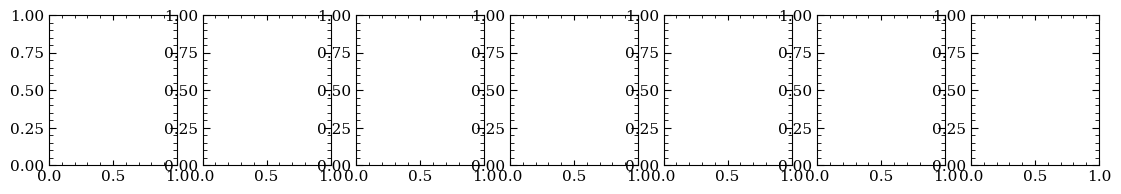

In [7]:
fig, axs = plt.subplots(1, 7, figsize=(10.5,1.5))

axs[0].imshow(img_nopsf); axs[0].set_title('Source')
axs[1].imshow(img_psf); axs[1].set_title('Source+PSF')

axs[2].imshow(np.log10(np.abs(img_fft)), vmin=-5, vmax=5); axs[2].set_title('F(Source+PSF)')
axs[3].imshow(np.log10(np.abs(img_nopsf_fft)), vmin=-5,vmax=5); axs[3].set_title('F(source)')
axs[4].imshow(np.log10(np.abs(psf_fft)), vmin=-5,vmax=5); axs[4].set_title('F(PSF)')
axs[5].imshow(np.log10(np.abs(img_fft/psf_fft)), vmin=-5,vmax=5); axs[5].set_title('F(source+psf)/F(psf)')
axs[6].imshow(np.log10(np.abs(img_nopsf_fft*psf_fft)), vmin=-5,vmax=5); axs[6].set_title('F(source)*F(psf)')

for ax in axs:
    ax.axis('off')
plt.subplots_adjust(wspace=0.05)
# source_fft = fft.fft2(img_nopsf)
# psf_fft = fft.fft2(psf)

# source_fft.shape, psf_fft.shape

In [ ]:
original = img_fft.copy()
original /= psf_fft
original = fft.ifft2(original)
# original = fft.fftshift(original)

In [ ]:
plt.imshow(np.abs(original[PAD:XSIZE-PAD,PAD:XSIZE-PAD]), vmin=0, vmax=2000)

In [ ]:
plt.imshow(np.abs(img_nopsf[PAD:XSIZE-PAD,PAD:XSIZE-PAD]), vmin=0, vmax=2000)

## Sums

In [8]:
N = img_fft.shape[0]*img_fft.shape[1]

flux_f = np.sum(img_nopsf**2)
flux_fimg = np.sum(img_psf**2)

flux_f_fft = np.sum(np.abs(img_nopsf_fft)**2) / N
flux_fimg_fft = np.sum(np.abs(img_fft)**2) / N

flux_fcorr_fft = np.sum( np.abs(img_fft)**2 / np.abs(psf_fft)**2 ) / N

print(f'Source flux^2: {flux_f:0.2E}')
print(f'Image flux^2: {flux_fimg:0.2E}')

print()

print(f'FFT Source flux^2: {flux_f_fft:0.2E}')
print(f'FFT Image flux^2: {flux_fimg_fft:0.2E}')

print()

print(f'FFT Image corr. flux^2: {flux_fcorr_fft:0.2E}')

NameError: name 'img_fft' is not defined

In [9]:
(7.41-6.68)/7.41

0.0985155195681512

## Test as a function of pixel scale, PSF size

In [10]:
def get_fluxes(pxscale, psf_fwhm, use_moffat=False):
    
    # Generate galaxies
    field_image, galaxy, r_pet = get_perfect_galaxy(mag, r, fov_reff=10.5, pxscale=pxscale, q=q, return_image=False)
    img_nopsf = get_realistic_galaxy(field_image, galaxy, r_pet, mag, pxscale=pxscale,
                                   sky_mag=None, n_clumps=len(clump_properties['r']), psf_fwhm=0, 
                                   clump_properties=clump_properties, use_moffat=use_moffat)
    img_psf = get_realistic_galaxy(field_image, galaxy, r_pet, mag, pxscale=pxscale,
                                   sky_mag=None, n_clumps=len(clump_properties['r']), psf_fwhm=psf_fwhm, 
                                   clump_properties=clump_properties, use_moffat=use_moffat)
    N = img_psf.shape[0]
    
    
    # Generate PSF
    # psf_fwhm = np.abs(psf_fwhm + norm.rvs(loc=0, scale=0.1, size=1))
    psf_std = psf_fwhm * gaussian_fwhm_to_sigma / pxscale
    # power = 2.45
    # psf_std = (psf_fwhm/pxscale) / np.sqrt( 8 * (power-1) * (2**(1/power) - 1 ) )
    psf = Gaussian2DKernel(x_stddev=psf_std, x_size=N, y_size=N)
    
    # Convert to Fourier space
    img_fft =(fft.fft2(img_psf))
    psf_fft = (fft.fft2(fft.fftshift(psf)))
    
    # Get rid of small modes that will blow up the result
    psf_fft[np.log10(np.abs(psf_fft)) < -2] = 1e-2
    
    # Compute the deconvolved image in PSF space
    deconv_fft = img_fft / psf_fft

    # Calculate total fluxes
    source_flux = np.sum(img_nopsf**2) / pxscale**2
    image_flux = np.sum(img_psf**2)/ pxscale**2
    corr_flux = np.sum( np.abs(deconv_fft)**2 ) / N**2 / pxscale**2 
    
    return np.array([source_flux, image_flux, corr_flux])

Run for a range of pixel scales & seeing values

In [45]:
num_points = 30
pxscales = np.linspace(0.1,2.0, num_points)
seeings = np.linspace(0.1,2.0, num_points)

fluxes = np.zeros((num_points, num_points, 3))

for i, pxscale in tqdm(enumerate(pxscales), total=num_points):
    for j, seeing in enumerate(seeings):

        fluxes[i,j,:] = get_fluxes(pxscale, seeing, use_moffat=True)

  0%|                                                                                            | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_10397/1169168880.py:26: RuntimeWarning: divide by zero encountered in log10
  psf_fft[np.log10(np.abs(psf_fft)) < -2] = 1e-2
100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:33<00:00,  1.11s/it]


Calculate errors:

In [46]:
error_image = (fluxes[:,:,1] - fluxes[:,:,0])/fluxes[:,:,0]
error_corr = (fluxes[:,:,2] - fluxes[:,:,0])/fluxes[:,:,0]

Plot errors:

Text(0, 0.5, 'Pixel scale [arcsec]')

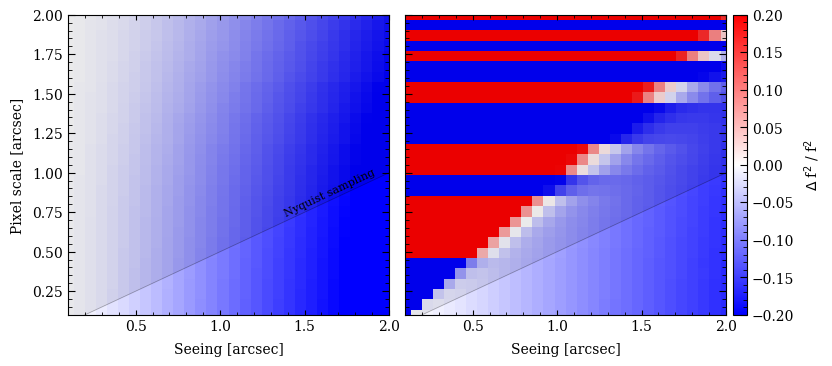

In [47]:
PXSCALE, SEEING = np.meshgrid(pxscales, seeings)
cmap = plt.get_cmap('bwr')
cmap.set_extremes(under='#ff0', over='#f0f')

fig, axs = plt.subplots(1,2, figsize=(7, 3), sharey=True)
axs[0].pcolormesh(PXSCALE, SEEING, error_image, vmax=0.2, vmin=-0.2, cmap='bwr')
im = axs[1].pcolormesh(PXSCALE, SEEING, error_corr, vmax=0.2, vmin=-0.2, cmap='bwr')

for ax in axs:
    ax.fill_between([0,2], [0,1], [2,2], color='k', alpha=0.08)
    ax.plot([0,2], [0,1], color='k', lw=0.5, alpha=0.3)
    ax.set_xlim(pxscales[0], pxscales[-1])
    ax.set_ylim(seeings[0], seeings[-1])
axs[0].annotate('Nyquist sampling', xy=(1.65, 1.65/2+0.05), rotation=25.3, ha='center', va='center', size=8)

plt.subplots_adjust(wspace=0.05, right=0.94)
cax = fig.add_axes([0.95,0,0.02,1])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r'$\Delta$ f$^2$ / f$^2$')

axs[0].set_xlabel('Seeing [arcsec]')
axs[1].set_xlabel('Seeing [arcsec]')
axs[0].set_ylabel('Pixel scale [arcsec]')

## Wrong shape of the PSF

"Typical" seeing is better described by a Moffat profile than a Gaussian PSF, so what happens if we *convolve* the image with a Moffat, but try to *deconvolve* using a Gaussian?

* Generate a Moffat profile, given some $\gamma$ (radius) and $\alpha$ (power)
* Try to fit a Gaussian to this profile to get the effective Gaussian FWHM

In [42]:
# def get_moffat_from_fwhm(moffat_fwhm, power=2.3):
    
#     # Calculate "gamma" from Moffat power and desired fwhm
#     gamma = fwhm / (2 * np.sqrt(2**(1/power) - 1))
#     print(gamma)


# # width = get_moffbat_width(psf_fwhm/pxscale, power)
# # psf_moffat = Moffat2DKernel(gamma=get_moffat_width(psf_fwhm/pxscale, power), 
# #                             alpha=power, x_size=img_psf.shape[1], y_size=img_psf.shape[0]).array

In [43]:
fwhm = 2
power = 2.0
gamma = fwhm / (2 * np.sqrt(2**(1/power) - 1))

moffat = Moffat2DKernel(gamma=gamma, alpha=power, x_size=11, y_size=11).array
gauss = Gaussian2DKernel(x_stddev=fwhm*gaussian_fwhm_to_sigma, x_size=11, y_size=11).array


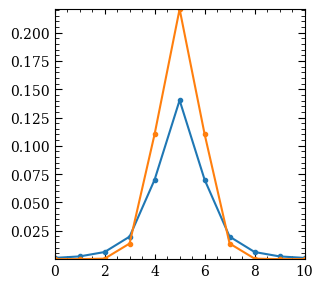

In [207]:
plt.plot(np.max(moffat, axis=0), '.-')
plt.plot(np.max(gauss, axis=0), '.-')

## Noise

I think the Fourier deconvolution is not robust to noise unfortunately... but let's find out

In [300]:
# def wiener(image, psf, bg_var):
    
#     N = image.shape[0] * image.shape[1]
#     if bg_var is None:
#         bg_var = 1e-3 
#         noise_sq = bg_var * N
#     else:
#         bg_var = np.max([bg_var, 1e-3]) 
#         # bg_var = 1e-3
#         noise_sq =  bg_var * N
    
#     transform = psf / (psf**2 + noise_sq/image**2)
#     # snr_sq = image**2 / noise_sq
#     # denom = psf**2 + 1/snr_sq
#     # transform = psf / denom
#     return image*transform

In [301]:
class fitQuadratic:
    
    def __init__(self, xc):
        self.xc = xc
    
    def quadratic(self, X, A, B, C, D):    
        # X should be 2xN array
        x, y = X
    
        # 2D quadratic function
        # f = (A*(x-self.xc)**2 + B) * (C*(y-self.xc)**2 + D)
        f = A*(x-self.xc)**2 *(y-self.xc)**2 + B*(x-self.xc)**2  + C*(y-self.xc)**2 + D
        return f

class fitQuadratic2:
    
    def __init__(self, xc):
        self.xc = xc
        
    def quadratic2(self, x, A, C):
        f = A * ((x-self.xc)**2 + C)
        return f

def get_snr_fit(image, std):

    xc = int(image.shape[0]/2)
    xs = np.arange(image.shape[0])
    XS, YS = np.meshgrid(xs, xs)
    snr = np.sqrt(image*np.conj(image) / std**2)# + np.abs(image)))  
    snr = np.abs(snr)
    
    # Select regions of the SNR array where SNR is high (not noise-dominated)
    # Select SNR lim
    snr_lim = np.quantile(snr, 0.9)
    snr_lim = np.min([snr_lim, 3])
    good_ids = np.nonzero(snr > snr_lim)

    good_log_snr = np.log10(snr[good_ids])
    good_xs = XS[good_ids]
    good_ys = YS[good_ids]
    
    fit_inst = fitQuadratic(xc)
    res = curve_fit(fit_inst.quadratic, np.array([good_xs, good_ys]), good_log_snr, bounds=([0,0,0,-np.inf],4*[np.inf]))[0]
    
    fit_snr = fit_inst.quadratic(np.array([XS,YS]), *res)
    fit_snr = np.power(10, fit_snr)
    # fit_snr[good_ids] = snr[good_ids]
    # fit_snr = fit_snr
    return fit_snr

In [304]:
def make_perfect_galaxy(
    mag, r_eff, fov_reff=10, pxscale=0.396, sersic_n=1, q=1, beta=0, 
    sky_mag=23.7,  psf_fwhm=1.32, rms_noise=True,
    n_clumps=10, clump_properties=None, random_clump_properties=None, use_moffat=False
):
    
    #################### SDSS set-up ###########################
    sdss_ra = 150
    sdss_dec = 2.3
    filt = 'r'
    bandpass_file = "passband_sdss_" + filt
    bandpass = galsim.Bandpass(bandpass_file, wave_type = u.angstrom)
    ## gain, exptime and diameter of telescope
    telescope_params = {'g':4.8, 't_exp':53.91, 'D':2.5}
    ## effective wavelength and width of filter
    transmission_params = {'eff_wav':616.5, 'del_wav':137}
    
    ############## Sersic profile only #########################
    # Calculate field of view in degrees
    fov = fov_reff * r_eff / 3600
    
    # generate blank image with fov and wcs info
    field_image, wcs = gen_image(sdss_ra, sdss_dec, pxscale, fov, fov)

    # create a galaxy with given params
    galaxy = gen_galaxy(mag=mag, re=r_eff, n=sersic_n, q=q, beta=beta, telescope_params=telescope_params, 
                        transmission_params=transmission_params, bandpass=bandpass)
    
    # get petrosian radius of galaxy in px
    r_pet = petrosian_sersic(fov, r_eff, 1)/pxscale
    
    ############## Asymmetry clumps ############################
     # generate all the clumps and their positions
    clumps, all_xi, all_yi = create_clumps(field_image, r_pet, n_clumps, mag, telescope_params, transmission_params, bandpass,
                                           clump_properties, random_clump_properties)
    
    
    ############## Perfect image ###############################
    image_perfect = add_source_to_image(field_image, galaxy, clumps, all_xi, all_yi, 0, pxscale)

    
    ############## Convolved image #############################
    image_psf = add_source_to_image(field_image, galaxy, clumps, all_xi, all_yi, psf_fwhm, pxscale, use_moffat=use_moffat)
    
    
    ############## Add noise ####################################
    image_noise, noise = sky_noise(image_psf, sky_mag, pxscale, telescope_params, transmission_params, bandpass, rms_noise=rms_noise)
    
    return image_perfect, image_noise, noise

In [528]:
pxscale = 0.396
psf_fwhm = 3
psf_std = psf_fwhm * gaussian_fwhm_to_sigma
fft_norm = 'backward'
sersic_n = 4

n_clumps = len(clump_properties['r'])
n_clumps = 0

img_nopsf, img_psf, noise = make_perfect_galaxy(mag, r, 10.5, pxscale, q=q, sersic_n=sersic_n, n_clumps=n_clumps, 
                                                clump_properties=clump_properties,
                                                sky_mag=30, psf_fwhm=psf_fwhm)

psf = Gaussian2DKernel(x_stddev=psf_std/pxscale, x_size=img_psf.shape[1], y_size=img_psf.shape[0]).array

# power = 2.45
# psf_std = (psf_fwhm/pxscale) / np.sqrt( 8 * (power-1) * (2**(1/power) - 1 ) )
# psf = Gaussian2DKernel(x_stddev=psf_std, x_size=img_psf.shape[1], y_size=img_psf.shape[0]).array

img_fft =(fft.fft2(img_psf, norm=fft_norm))
psf_fft = (fft.fft2(fft.fftshift(psf), norm=fft_norm))
img_nopsf_fft = (fft.fft2(img_nopsf, norm=fft_norm))

N = img_fft.shape[0]
noise_fft = noise * N

# * img_fft.shape[1]
# psf_fft[np.log10(np.abs(psf_fft)) < -3] = 1e-3  #1/(N*np.sqrt(noise))
# psf_fft[(np.abs(psf_fft)) < 0.2] = 0.2


In [529]:
def wiener(image, psf, bg_std, source=None):
    
    N = image.shape[0] 
        
    if source is None: source = image
    if bg_std is None: bg_std = 1e-2
    bg_std = np.max([bg_std, 1e-2]) 
    
    noise = bg_std 
    snr = source/noise
    transform = psf / (psf**2 + (snr)**(-2))
    
    return image*transform

In [530]:
def fit_H(img_fft, psf_fft):
    
    # Image x, y arrays
    xc = int(img_fft.shape[0]/2)
    xs = np.arange(img_fft.shape[0])
    XS, YS = np.meshgrid(xs, xs)

    # Calculate SNR
    snr = np.sqrt(img_fft*np.conj(img_fft) / (noise_fft**2 + np.abs(img_fft))) 
    snr = np.abs(snr)
    
    # Choose indices where SNR is high 
    snr_lim = np.quantile(snr, 0.99)
    snr_lim = np.max([snr_lim, 4])
    good_ids = np.nonzero(snr >snr_lim)
    good_log_snr = np.log10(snr[good_ids])
    good_xs = XS[good_ids]
    good_ys = YS[good_ids]
    
    # Use that to fit the real SNR for low-SNR regions
    fit_inst = fitQuadratic(xc)
    res = curve_fit(fit_inst.quadratic, np.array([good_xs, good_ys]), good_log_snr, bounds=([0,0,0,-np.inf],4*[np.inf]))[0]

    # Rewrite high-SNR regions with the real values
    fit_snr = fit_inst.quadratic(np.array([XS,YS]), *res)
    fit_snr = np.power(10, fit_snr)
    fit_snr[good_ids] = snr[good_ids]
    
    # Calculate H
    snr_inv_sq = 1/fit_snr**2
    H = np.sqrt((1 + snr_inv_sq) / ( psf_fft*np.conj(psf_fft) + snr_inv_sq) )
    
    return H
    

In [531]:
bg = norm.rvs(loc=0, scale=noise, size=img_fft.shape)
bg_fft = fft.fft2(bg, norm=fft_norm)

In [532]:
xc = int(img_fft.shape[0]/2)
xs = np.arange(img_fft.shape[0])
XS, YS = np.meshgrid(xs, xs)

# snr = np.sqrt(img_fft*np.conj(img_fft) / (noise_fft**2 + np.abs(img_fft)))  
# snr_real = np.sqrt(img_nopsf_fft*np.conj(img_nopsf_fft) / (noise_fft**2  + np.std(np.abs(img_nopsf_fft)) ))
# snr = np.abs(snr)

snr = np.sqrt(img_fft*np.conj(img_fft) / (noise_fft**2 ))  
snr_real = np.sqrt(img_nopsf_fft*np.conj(img_nopsf_fft) / (noise_fft**2   ))
snr = np.abs(snr)

# Select regions of the SNR array where SNR is high (not noise-dominated)
snr_lim = np.quantile(snr, 0.99)
snr_lim = np.max([snr_lim, 4])
good_ids = np.nonzero(snr >snr_lim)
good_log_snr = np.log10(snr[good_ids])
good_xs = XS[good_ids]
good_ys = YS[good_ids]
print(snr_lim)

fit_inst = fitQuadratic(xc)
res = curve_fit(fit_inst.quadratic, np.array([good_xs, good_ys]), good_log_snr, bounds=([0,0,0,-np.inf],4*[np.inf]))[0]

fit_snr = fit_inst.quadratic(np.array([XS,YS]), *res)
fit_snr = np.power(10, fit_snr)
fit_snr[good_ids] = snr[good_ids]

2601.194222375075


/tmp/ipykernel_16591/4032367624.py:2: RuntimeWarning: divide by zero encountered in log10
  ys = np.power(10, -2*np.log10(xs) + 1)
/home/liza/miniconda3/envs/astro/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


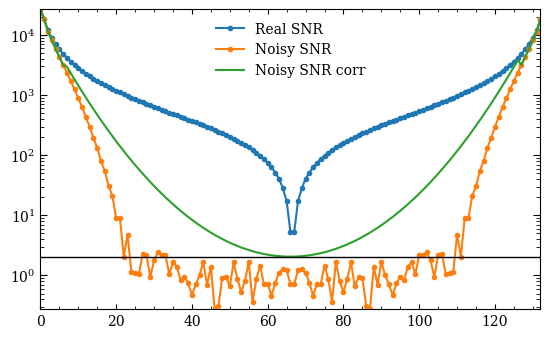

In [533]:
xs = np.arange(img_fft.shape[0])
ys = np.power(10, -2*np.log10(xs) + 1)

plt.figure(figsize=(5,3))
plt.plot(snr_real[0], '.-', label='Real SNR')
plt.plot(snr[0], '.-', label='Noisy SNR')
plt.plot(fit_snr[0], label='Noisy SNR corr')

plt.axhline(2, lw=1, color='k')
    
plt.legend()
plt.yscale('log')
# plt.ylim(1e-7, 1e2)
# plt.xscale('log')

(0.1, 1000.0)

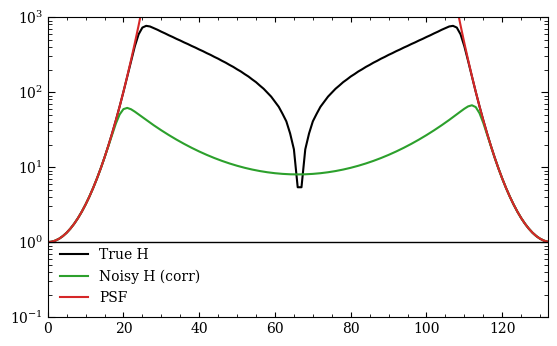

In [534]:
ws = np.abs(np.linspace(-66, 66, img_fft.shape[0]))

snr_inv_sq_real = 1/snr_real**2
snr_inv_sq = 1/snr**2
snr_inv_sq_corr = 1/fit_snr**2

h1 = np.sqrt((1 + snr_inv_sq_real) / ( psf_fft*np.conj(psf_fft) + snr_inv_sq_real ) )
h2 = np.sqrt((1 + snr_inv_sq_corr) / ( psf_fft*np.conj(psf_fft) + snr_inv_sq_corr) )
h2 = fit_H(img_fft, psf_fft)

plt.figure(figsize=(5,3))

plt.plot( h1[0], label='True H', color='k')
plt.plot( h2[0], label='Noisy H (corr)', color='C2')
plt.plot( np.abs(1/psf_fft[0]), label='PSF', color='C3')
plt.axhline(1, lw=1, color='k')
    
plt.legend()
plt.yscale('log')
plt.ylim(1e-1, 1e3)
# plt.xscale('log')

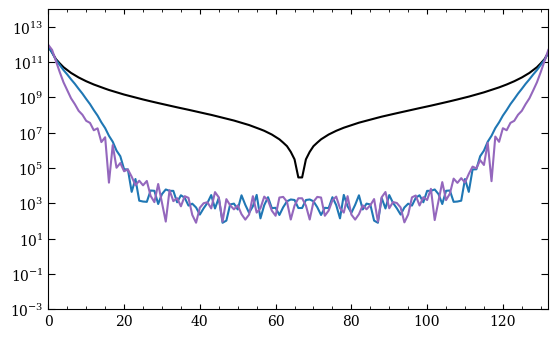

In [535]:
plt.figure(figsize=(5,3))

plt.plot( (img_nopsf_fft*np.conj(img_nopsf_fft))[0], label='Source', color='k')
plt.plot( (img_fft*np.conj(img_fft))[0], label='Image', color='C0')
# plt.plot( (img_fft*np.conj(img_fft)/(psf_fft*np.conj(psf_fft)))[0], label='Image', color='C1')
# plt.plot( (h1**2)[0], label='H', color='C3')
# plt.plot( np.abs((img_fft*h1)**2)[0], label='Img*H', color='C1')

H_wiener = psf_fft  / (psf_fft*np.conj(psf_fft) + snr_inv_sq)

# plt.plot( (img_wiener*np.conj(img_wiener))[0], label='Wiener', color='C2')
# plt.plot( (bg_fft*np.conj(bg_fft))[0], label='Noise', color='#0003', lw=1)
# plt.axhline(noise_fft**2, color='#0003', lw=1)
plt.plot( (naive*np.conj(naive))[0], label='Naive', color='C4')
# plt.plot(np.abs(low_f[0]), label='low-f', color='C3')
# plt.plot( ((H_wiener*np.conj(H_wiener)))[0], color='C2', label='Wiener H', alpha=1)
# plt.plot( (1/(psf_fft*np.conj(psf_fft)))[0], color='C3', label='Wiener H', alpha=1, ls='--')

     
# plt.legend()
plt.ylim(1e-3, 1e14)
plt.yscale('log')

Source: 17.69032704
Image: 6.93893450464449
Noisy, no seeing 17.690203112102743
---
Wiener: 16.381006306934708
Naive: 17.812812084322697


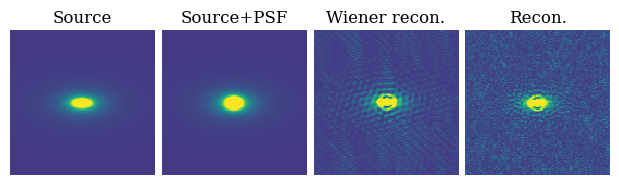

In [539]:
img_wiener = wiener(img_fft, psf_fft, noise_fft, img_nopsf_fft)
# noise_sq = noise_fft**2 + img_nopsf_fft
# snr_inv_sq = noise_sq / (img_nopsf_fft*np.conj(img_nopsf_fft))
naive = img_fft * h1#np.sqrt( (1 + snr_inv_sq) / ( psf_fft*np.conj(psf_fft) + snr_inv_sq) )

recon = np.abs(fft.ifft2(img_wiener, norm=fft_norm))
# recon2 = np.abs(fft.ifft2(img_fft*h1, norm=fft_norm))
recon2 = np.abs(fft.ifft2(img_fft*h1, norm=fft_norm))


fig, axs = plt.subplots(1, 4, figsize=(6,1.5))
axs[0].imshow(img_nopsf, vmin=-200, vmax=1000); axs[0].set_title('Source')
axs[1].imshow(img_psf, vmin=-200, vmax=1000); axs[1].set_title('Source+PSF')
axs[2].imshow(recon, vmin=-200, vmax=1000); axs[2].set_title('Wiener recon.')
axs[3].imshow(recon2, vmin=-200, vmax=1000); axs[3].set_title('Recon.')

for ax in axs:
    ax.axis('off')
plt.subplots_adjust(wspace=0.05)

print('Source:' , np.sum(img_nopsf**2)/1e8)
print('Image:', (np.sum(img_psf**2) - (noise*N)**2)/1e8 )
print('Noisy, no seeing', (np.sum( (img_nopsf+bg)**2) - (noise*N)**2)/1e8)
print('---')
print('Wiener:' , np.sum(np.abs(img_wiener**2))/1e8/N**2)
print('Naive:', ( ( np.sum(np.real(naive*np.conj(naive))) - (noise_fft*N)**2) /N**2  /1e8   ))


Source: 17.69032704
Image: 6.93893450464449
Noisy, no seeing 17.690203112102743
---
Wiener: 14.458031762414114
Naive: 14.57993671674545


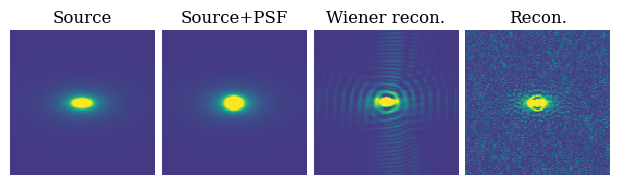

In [537]:
img_wiener = wiener(img_fft, psf_fft, noise_fft)#, img_nopsf_fft)
naive = img_fft * h2

recon = np.abs(fft.ifft2(img_wiener, norm=fft_norm))
# recon2 = np.abs(fft.ifft2(img_fft*h1, norm=fft_norm))
recon2 = np.abs(fft.ifft2(img_fft*h1, norm=fft_norm))

fig, axs = plt.subplots(1, 4, figsize=(6,1.5))
axs[0].imshow(img_nopsf, vmin=-200, vmax=1000); axs[0].set_title('Source')
axs[1].imshow(img_psf, vmin=-200, vmax=1000); axs[1].set_title('Source+PSF')
axs[2].imshow(recon, vmin=-200, vmax=1000); axs[2].set_title('Wiener recon.')
axs[3].imshow(recon2, vmin=-200, vmax=1000); axs[3].set_title('Recon.')

for ax in axs:
    ax.axis('off')
plt.subplots_adjust(wspace=0.05)

print('Source:' , np.sum(img_nopsf**2)/1e8)
print('Image:', (np.sum(img_psf**2) - (noise*N)**2)/1e8 )
print('Noisy, no seeing', (np.sum( (img_nopsf+bg)**2) - (noise*N)**2)/1e8)
print('---')
print('Wiener:' , np.sum(np.abs(img_wiener**2))/1e8/N**2)
print('Naive:', ( ( np.sum(np.real(naive*np.conj(naive))) - (noise_fft*N)**2) /N**2  /1e8   ))


Calculate asymmetry:

In [472]:
(np.sum( (recon2 - T.rotate(recon2, 180, order=0))**2 ) - 2*(N*noise)**2)/(np.sum(recon2**2) - (N*noise)**2)

-0.5306865185730821

In [473]:
img_rotated = T.rotate(img_nopsf, 180, order=0)
img_rotated_fft = fft.fft2(T.rotate(img_psf, 180, order=0))

true_a = np.sum( (img_nopsf-img_rotated)**2) / np.sum(img_nopsf**2)

rec_top = img_fft-img_rotated_fft
rec_top = np.sum(np.real(rec_top*np.conj(rec_top)*h2**2))/N**2 - 2*(N*noise)**2
rec_bot = np.sum(img_fft*h2*np.conj(img_fft*h2))/N**2 - (N*noise)**2
rec_a = np.abs(rec_top / rec_bot)

print('True A:', true_a)
print('Recovered A:', rec_a)

True A: 0.20663083
Recovered A: 0.14565184412221607


Try this for a range of seeing, noise:

In [ ]:
def get_fluxes(noise, psf_fwhm, pxscale=0.05,  use_moffat=False):
    
    # Generate galaxies
    field_image, galaxy, r_pet = get_perfect_galaxy(mag, r, fov_reff=10.5, pxscale=pxscale, q=q, return_image=False)
    img_nopsf, _ = get_realistic_galaxy(field_image, galaxy, r_pet, mag, pxscale=pxscale,
                                   sky_mag=None, n_clumps=len(clump_properties['r']), psf_fwhm=0, 
                                   clump_properties=clump_properties, use_moffat=use_moffat)
    img_psf, noise = get_realistic_galaxy(field_image, galaxy, r_pet, mag, pxscale=pxscale,
                                   sky_mag=noise, n_clumps=len(clump_properties['r']), psf_fwhm=psf_fwhm, 
                                   clump_properties=clump_properties, use_moffat=use_moffat)
    N = img_psf.shape[0]
    noise_fft = noise * N
    
    # Generate PSF
    # psf_fwhm = np.abs(psf_fwhm + norm.rvs(loc=0, scale=0.1, size=1))
    psf_std = psf_fwhm * gaussian_fwhm_to_sigma / pxscale
    # power = 2.45
    # psf_std = (psf_fwhm/pxscale) / np.sqrt( 8 * (power-1) * (2**(1/power) - 1 ) )
    psf = Gaussian2DKernel(x_stddev=psf_std, x_size=N, y_size=N)
    
    # Convert to Fourier space
    img_fft =(fft.fft2(img_psf))
    psf_fft = (fft.fft2(fft.fftshift(psf)))
    
    # Method 1: Wiener transform
    img_wiener = wiener(img_fft, psf_fft, noise_fft)
    
    # Get rid of small modes that will blow up the result
    psf_fft[np.log10(np.abs(psf_fft)) < -2] = 1e-2
    
    # Compute the deconvolved image in PSF space
    deconv_fft = img_fft / psf_fft

    # Calculate total fluxes
    source_flux = np.sum(img_nopsf**2) / pxscale**2
    image_flux = np.sum(img_psf**2)/ pxscale**2
    corr_flux = np.sum( np.abs(deconv_fft)**2 ) / N**2 / pxscale**2 
    
    return np.array([source_flux, image_flux, corr_flux])


num_points = 30
pxscales = np.linspace(0.1,2.0, num_points)
seeings = np.linspace(0.1,2.0, num_points)

fluxes = np.zeros((num_points, num_points, 3))

for i, pxscale in tqdm(enumerate(pxscales), total=num_points):
    for j, seeing in enumerate(seeings):

        fluxes[i,j,:] = get_fluxes(pxscale, seeing, use_moffat=True)
        
        
error_image = (fluxes[:,:,1] - fluxes[:,:,0])/fluxes[:,:,0]
error_corr = (fluxes[:,:,2] - fluxes[:,:,0])/fluxes[:,:,0]



Plot:

In [ ]:
PXSCALE, SEEING = np.meshgrid(pxscales, seeings)
cmap = plt.get_cmap('bwr')
cmap.set_extremes(under='#ff0', over='#f0f')

fig, axs = plt.subplots(1,2, figsize=(7, 3), sharey=True)
axs[0].pcolormesh(PXSCALE, SEEING, error_image, vmax=0.2, vmin=-0.2, cmap='bwr')
im = axs[1].pcolormesh(PXSCALE, SEEING, error_corr, vmax=0.2, vmin=-0.2, cmap='bwr')

for ax in axs:
    ax.fill_between([0,2], [0,1], [2,2], color='k', alpha=0.08)
    ax.plot([0,2], [0,1], color='k', lw=0.5, alpha=0.3)
    ax.set_xlim(pxscales[0], pxscales[-1])
    ax.set_ylim(seeings[0], seeings[-1])
axs[0].annotate('Nyquist sampling', xy=(1.65, 1.65/2+0.05), rotation=25.3, ha='center', va='center', size=8)

plt.subplots_adjust(wspace=0.05, right=0.94)
cax = fig.add_axes([0.95,0,0.02,1])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r'$\Delta$ f$^2$ / f$^2$')

axs[0].set_xlabel('Seeing [arcsec]')
axs[1].set_xlabel('Seeing [arcsec]')
axs[0].set_ylabel('Pixel scale [arcsec]')

In [258]:
test = 'abcdefg'

In [262]:
test[-4:] = '####'

TypeError: 'str' object does not support item assignment